In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from env import user, password, host
#import acquire
#import prepare
import explore

# Project Planning <br>
##### Acquire Date -> Prepare Data -> Explore Data -> Create Model -> Train Model -> Validate Model -> Test Model -> Present Findings

# Acquire Data <br>
###### Creating functions that will import data

In [2]:
# this function be used to access the SQL server
# the user, host, and password will come from importing 'env'

def get_connection(db, user=user, host=host, password=password):
    '''
    This function creates a connection to the Codeup db.
    It takes db argument as a string name.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def new_telco_data():
    '''
    This function gets new telco data from the Codeup database.
    '''
    sql_query = """
                SELECT *
                FROM customers
                JOIN contract_types USING(contract_type_id)
                JOIN internet_service_types USING(internet_service_type_id)
                JOIN payment_types USING(payment_type_id);
                """
    # Read in dataframe from Codeuo
    df = pd.read_sql(sql_query,get_connection('telco_churn'))
    return df

In [4]:
def get_telco_data():
        '''
        This function gets telco data from csv, or otherwise from Codeup database.
        '''
        if os.path.isfile('telco.csv'):
            df = pd.read_csv('telco.csv', index_col = 0)
        else:
            df = new_telco_data()
            df.to_csv('telco.csv')
        return df

In [5]:
df = get_telco_data()
df.head

<bound method NDFrame.head of       payment_type_id  internet_service_type_id  contract_type_id customer_id  \
0                   2                         1                 3  0016-QLJIS   
1                   4                         1                 3  0017-DINOC   
2                   3                         1                 3  0019-GFNTW   
3                   4                         1                 3  0056-EPFBG   
4                   3                         1                 3  0078-XZMHT   
...               ...                       ...               ...         ...   
7038                2                         3                 1  9962-BFPDU   
7039                2                         3                 1  9967-ATRFS   
7040                4                         3                 1  9970-QBCDA   
7041                2                         3                 1  9975-SKRNR   
7042                3                         3                 1  9986-BONCE  

In [6]:
df = pd.DataFrame(df)
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [7]:
df.shape

(7043, 24)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [10]:
def object_vals(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(df[col].value_counts(dropna = False))

In [11]:
def col_range(df):
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [12]:
# Create a function to summaris my dataframe

def summarize_df(df):
    print(f'The dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('------------------------------------------------------')
    print(df.info())
    print('------------------------------------------------------')
    print(df.head())
    print('------------------------------------------------------')
    object_vals(df)
    print('------------------------------------------------------')
    print(col_range(df))
    

In [13]:
summarize_df(df)

The dataframe has 7043 rows and 24 columns.
------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup      

# Prepare Data

In [14]:
# Check for null values
# No nulls found

df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [15]:
def telco_split(df):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=123, 
                                            stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=123,
                                       stratify=train_validate.churn)
    return train, validate, test

In [52]:
def prep_telco(df):
    '''
    This function takes in df that was acquired from get_telco_data.
    Then it drops the SQL foreign keys, which are unnecessary:
    payment_type_id, internet_service_type_id, contract_type_id
    '''
    
    # Get rid of any duplicate records
    df = df.drop_duplicates()
    
     # Create a new column to show if payment was automatic
    df['automatic_pmt'] = np.where(df['payment_type'].str.contains("automatic", case=False), 1, 0)
    
    # Create dummies dataframe
    # .get_dummies(column_names,not dropping any of the dummy columns)
    #dummy_features = ['multiple_lines','online_security','online_backup',
    #                  'device_protection','tech_support','streaming_tv',
    #                  'streaming_movies','contract_type','internet_service_type',
    #                  'payment_type']
    #dummy_df = pd.get_dummies(df, columns=dummy_features, drop_first=False)
    
    # Join original df with dummies df
    # .concat([original_df,dummy_df])
    #df = pd.concat([df, dummy_df])
    
    # Drop original columns that we made dummies of
    #df = df.drop(columns=dummy_features)
    
    # Replace string values with numbers
    #df.replace({'gender':{'Male':1, 'Female':0}}, inplace=True)
    df.replace({'partner':{'Yes':1, 'No':0}}, inplace=True)
    df.replace({'dependents':{'Yes':1, 'No':0}}, inplace=True)
    #df.replace({'phone_service':{'Yes':1, 'No':0}}, inplace=True)
    df.replace({'paperless_billing':{'Yes':1, 'No':0}}, inplace=True)
    df.replace({'churn':{'Yes':1, 'No':0}}, inplace=True)
    
    df.replace({'multiple_lines':{'Yes':1, 'No':0, 'No phone service':-1}}, inplace=True)
    df.replace({'device_protection':{'Yes':1, 'No':0, 'No internet service':-1}}, inplace=True)
    df.replace({'online_security':{'Yes':1, 'No':0, 'No internet service':-1}}, inplace=True)
    df.replace({'online_backup':{'Yes':1, 'No':0, 'No internet service':-1}}, inplace=True)
    df.replace({'tech_support':{'Yes':1, 'No':0, 'No internet service':-1}}, inplace=True)
    df.replace({'streaming_tv':{'Yes':1, 'No':0, 'No internet service':-1}}, inplace=True)
    df.replace({'streaming_movies':{'Yes':1, 'No':0, 'No internet service':-1}}, inplace=True)
    df.replace({'contract_type':{'Month-to-month':0, 'One year':1, 'Two year':2}}, inplace=True)
    df.replace({'internet_service_type':{'None':0, 'DSL':1, 'Fiber optic':2}}, inplace=True)
    df.replace({'payment_type':{'Mailed check':0, 'Electronic check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3}}, inplace=True)
    
    # Create new feature to combine online utility options
    # These online options did not seem popular during univariate exploration
    df['online_utility']= df.online_security + df.online_backup + df.tech_support
    
    # Create new feature to combine streaming options, because they are very similar
    df['streaming']= df.streaming_tv + df.streaming_movies
    
    # Drop the unnecessary colums
    df = df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id', 'online_security', 'online_backup', 'tech_support', 'streaming_tv', 'streaming_movies', 'phone_service', 'gender','total_charges'])    
    
    # Convert total_charges to a numeric data type (is currently string type)
    #df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
    # There are 7 null values in total_charges
    # Replace those 7 null values with median value
    #df.total_charges.fillna(df.total_charges.median(), inplace=True)
    
    # Split the dataset into train, validate, and test subsets
    train, validate, test = telco_split(df)
    
    return train, validate, test

In [53]:
# Split the dataset into train, validate, and test data subsets

train, validate, test = prep_telco(df)
print('The shape of the data subsets:')
print(f'train    -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test     -> {test.shape}')

The shape of the data subsets:
train    -> (3943, 15)
validate -> (1691, 15)
test     -> (1409, 15)


In [54]:
# Verify that all cells contain numeric values

train

,senior_citizen,partner,dependents,tenure,multiple_lines,device_protection,paperless_billing,monthly_charges,churn,contract_type,internet_service_type,payment_type,automatic_pmt,online_utility,streaming
5642,0,1,1,23,1,-1,1,25.60,0,2,0,3,1,-3,-2
3338,0,0,0,27,1,1,1,100.50,0,1,2,2,1,0,2
4273,1,0,0,7,0,0,1,89.15,0,0,2,1,0,0,2
2382,0,1,0,47,0,0,1,58.60,0,0,1,2,1,1,1
2655,0,0,0,41,0,0,1,99.65,0,2,2,3,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,0,1,1,13,1,0,1,74.40,1,0,2,3,1,0,0
262,0,1,0,33,-1,1,0,59.55,0,2,1,2,1,2,2
3271,0,1,0,67,1,1,0,104.10,1,1,2,1,0,1,2
3150,0,0,0,69,1,0,1,105.20,0,1,2,2,1,2,2


In [55]:
# All columns have a numeric data type

train.dtypes

senior_citizen             int64
partner                    int64
dependents                 int64
tenure                     int64
multiple_lines             int64
device_protection          int64
paperless_billing          int64
monthly_charges          float64
churn                      int64
contract_type              int64
internet_service_type      int64
payment_type               int64
automatic_pmt              int64
online_utility             int64
streaming                  int64
dtype: object

In [56]:
# Checking for nulls after preparing data

train.isnull().sum()

senior_citizen           0
partner                  0
dependents               0
tenure                   0
multiple_lines           0
device_protection        0
paperless_billing        0
monthly_charges          0
churn                    0
contract_type            0
internet_service_type    0
payment_type             0
automatic_pmt            0
online_utility           0
streaming                0
dtype: int64

# Explore Data

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5642 to 6840
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   senior_citizen         3943 non-null   int64  
 1   partner                3943 non-null   int64  
 2   dependents             3943 non-null   int64  
 3   tenure                 3943 non-null   int64  
 4   multiple_lines         3943 non-null   int64  
 5   device_protection      3943 non-null   int64  
 6   paperless_billing      3943 non-null   int64  
 7   monthly_charges        3943 non-null   float64
 8   churn                  3943 non-null   int64  
 9   contract_type          3943 non-null   int64  
 10  internet_service_type  3943 non-null   int64  
 11  payment_type           3943 non-null   int64  
 12  automatic_pmt          3943 non-null   int64  
 13  online_utility         3943 non-null   int64  
 14  streaming              3943 non-null   int64  
dtypes

In [58]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
senior_citizen,3943.0,0.162313,0.368784,0.00,0.0,0.0,0.00,1.00
partner,3943.0,0.481613,0.499725,0.00,0.0,0.0,1.00,1.00
dependents,3943.0,0.299011,0.457883,0.00,0.0,0.0,1.00,1.00
tenure,3943.0,32.673852,24.472862,0.00,9.0,29.0,56.00,72.00
multiple_lines,3943.0,0.322851,0.646579,-1.00,0.0,0.0,1.00,1.00
device_protection,3943.0,0.144814,0.740972,-1.00,0.0,0.0,1.00,1.00
paperless_billing,3943.0,0.589399,0.492005,0.00,0.0,1.0,1.00,1.00
monthly_charges,3943.0,65.102790,30.128631,18.55,36.2,70.4,90.05,118.65
churn,3943.0,0.265280,0.441538,0.00,0.0,0.0,1.00,1.00
contract_type,3943.0,0.698707,0.839485,0.00,0.0,0.0,1.00,2.00


In [60]:
# I will be using the functions from explore.py given by the Codeup staff

# Choosing categorical variables
cat_vars = ['senior_citizen', 'partner', 'dependents','multiple_lines',
            'paperless_billing','churn','contract_type','internet_service_type',
            'payment_type','automatic_pmt','online_utility','streaming']

# Choosing quantitative variables
quant_vars = ['tenure', 'monthly_charges']

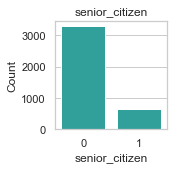

   senior_citizen  Count  Percent
0               0   3303    83.77
1               1    640    16.23
_________________________________________________________________


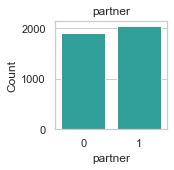

   partner  Count  Percent
0        1   2044    51.84
1        0   1899    48.16
_________________________________________________________________


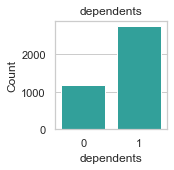

   dependents  Count  Percent
0           1   2764     70.1
1           0   1179     29.9
_________________________________________________________________


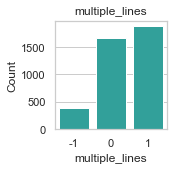

    multiple_lines  Count  Percent
 0               1   1884    47.78
 1               0   1666    42.25
-1              -1    393     9.97
_________________________________________________________________


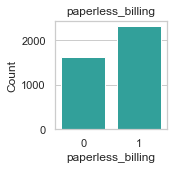

   paperless_billing  Count  Percent
1                  1   2324    58.94
0                  0   1619    41.06
_________________________________________________________________


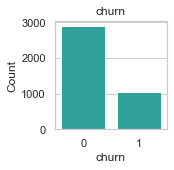

   churn  Count  Percent
0      0   2897    73.47
1      1   1046    26.53
_________________________________________________________________


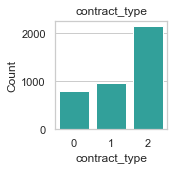

   contract_type  Count  Percent
0              2   2162    54.83
2              1    974    24.70
1              0    807    20.47
_________________________________________________________________


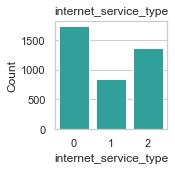

   internet_service_type  Count  Percent
2                      0   1740    44.13
1                      2   1365    34.62
0                      1    838    21.25
_________________________________________________________________


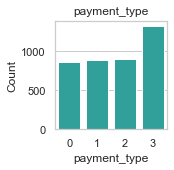

   payment_type  Count  Percent
1             3   1320    33.48
0             2    892    22.62
2             1    879    22.29
3             0    852    21.61
_________________________________________________________________


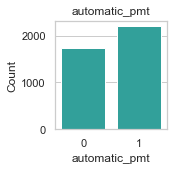

   automatic_pmt  Count  Percent
0              1   2212     56.1
1              0   1731     43.9
_________________________________________________________________


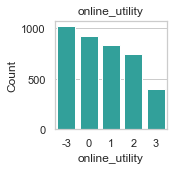

    online_utility  Count  Percent
 1              -3   1026    26.02
 0               0    926    23.48
-3               1    838    21.25
 2               2    750    19.02
 3               3    403    10.22
_________________________________________________________________


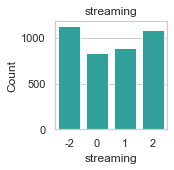

    streaming  Count  Percent
 0         -2   1132    28.71
 2          2   1089    27.62
 1          1    884    22.42
-2          0    838    21.25
_________________________________________________________________


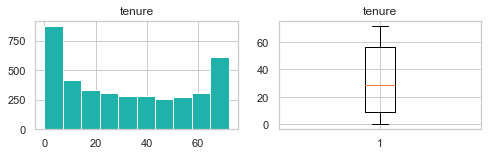

count    3943.000000
mean       32.673852
std        24.472862
min         0.000000
25%         9.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64


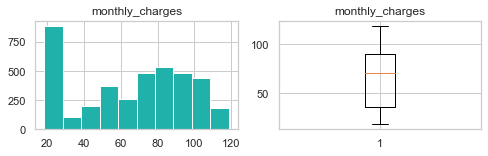

count    3943.000000
mean       65.102790
std        30.128631
min        18.550000
25%        36.200000
50%        70.400000
75%        90.050000
max       118.650000
Name: monthly_charges, dtype: float64


In [61]:
# This is one of the functions from explore.py
# This function examines univariate relationships between the features

explore.explore_univariate(train, cat_vars, quant_vars)

### Takeaways from univariate analysis <br>
- Gender is approximately half and half <br>
- Most customers (83%) are not senior citizens <br>
- Approximately half of customers have partners <br>
- Most customers (69%) do not have dependents <br>
- Most customers (90%) do have phone service <br>
- In terms of customers having internet: none > DSL > fiber optic
- Most customers do not have the bells and whistles (online security/backup, tech support) <br>
- However, most customers with internet do have device protection <br>
- Most customers with internet do have streaming movies/tv <br>
- The most common contract length is 2 years, but 1 year is only slightly higher than month-to-month <br>
- Most customers have paperless billing <br>
- Most customers have autopay <br>
- Credit card (autopay) is the most common payment type, the other types are similar to each other <br>
- Tenure looks like an upside-down bell curve, with peaks on either tail <br>
- Monthly charges looks like a bell curve, but right skewed and with a large peak on the right tail (lowest cost)
- Total charges peaks at the lowest cost, then has several large drops, then the number of customers with higher charges continually shrinks

senior_citizen 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2       p-value  degrees of freedom
0  106.962416  4.536923e-25                   1

observed:
 churn              0     1   All
senior_citizen                  
0               2533   770  3303
1                364   276   640
All             2897  1046  3943

expected:
              0           1
0  2426.779356  876.220644
1   470.220644  169.779356


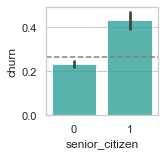


_____________________

partner 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


        chi2       p-value  degrees of freedom
0  74.137206  7.287185e-18                   1

observed:
 churn       0     1   All
partner                  
0        1382   662  2044
1        1515   384  1899
All      2897  1046  3943

expected:
              0           1
0  1501.767182  542.232818
1  1395.232818  503.767182


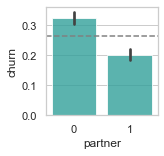


_____________________

dependents 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2       p-value  degrees of freedom
0  100.546984  1.156215e-23                   1

observed:
 churn          0     1   All
dependents                  
0           1903   861  2764
1            994   185  1179
All         2897  1046  3943

expected:
              0           1
0  2030.765407  733.234593
1   866.234593  312.765407


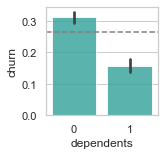


_____________________

multiple_lines 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


    chi2   p-value  degrees of freedom
0  6.928  0.031304                   2

observed:
 churn              0     1   All
multiple_lines                  
-1               295    98   393
0               1414   470  1884
1               1188   478  1666
All             2897  1046  3943

expected:
              0           1
0   288.744864  104.255136
1  1384.212021  499.787979
2  1224.043114  441.956886


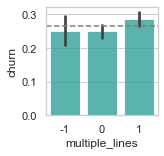


_____________________

paperless_billing 
_____________________

         chi2       p-value  degrees of freedom
0  137.624538  8.804467e-32                   1

observed:
 churn                 0     1   All
paperless_billing                  
0                  1350   269  1619
1                  1547   777  2324
All                2897  1046  3943

expected:
              0           1
0  1189.511286  429.488714
1  1707.488714  616.511286


/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


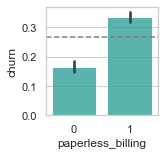


_____________________

contract_type 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2        p-value  degrees of freedom
0  670.960699  2.007869e-146                   2

observed:
 churn             0     1   All
contract_type                  
0              1234   928  2162
1               723    84   807
2               940    34   974
All            2897  1046  3943

expected:
              0           1
0  1588.464114  573.535886
1   592.918844  214.081156
2   715.617043  258.382957


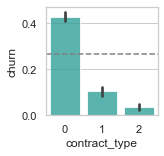


_____________________

internet_service_type 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2       p-value  degrees of freedom
0  398.382058  3.107673e-87                   2

observed:
 churn                     0     1   All
internet_service_type                  
0                       775    63   838
1                      1106   259  1365
2                      1016   724  1740
All                    2897  1046  3943

expected:
              0           1
0   615.695156  222.304844
1  1002.892468  362.107532
2  1278.412376  461.587624


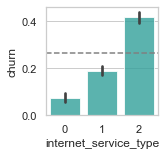


_____________________

payment_type 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2       p-value  degrees of freedom
0  352.123842  5.173628e-76                   3

observed:
 churn            0     1   All
payment_type                  
0              725   167   892
1              725   595  1320
2              730   149   879
3              717   135   852
All           2897  1046  3943

expected:
             0           1
0  655.370023  236.629977
1  969.830079  350.169921
2  645.818666  233.181334
3  625.981233  226.018767


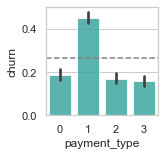


_____________________

automatic_pmt 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


        chi2       p-value  degrees of freedom
0  161.25169  6.028032e-37                   1

observed:
 churn             0     1   All
automatic_pmt                  
0              1450   762  2212
1              1447   284  1731
All            2897  1046  3943

expected:
              0           1
0  1625.200101  586.799899
1  1271.799899  459.200101


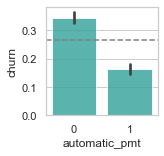


_____________________

online_utility 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2        p-value  degrees of freedom
0  688.727914  9.614147e-148                   4

observed:
 churn              0     1   All
online_utility                  
-3               775    63   838
0                419   507   926
1                689   337  1026
2                637   113   750
3                377    26   403
All             2897  1046  3943

expected:
             0           1
0  615.695156  222.304844
1  680.350495  245.649505
2  753.822470  272.177530
3  551.039817  198.960183
4  296.092062  106.907938


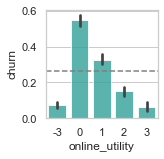


_____________________

streaming 
_____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


         chi2       p-value  degrees of freedom
0  202.117748  1.470835e-43                   3

observed:
 churn         0     1   All
streaming                  
-2          775    63   838
0           752   380  1132
1           602   282   884
2           768   321  1089
All        2897  1046  3943

expected:
             0           1
0  615.695156  222.304844
1  831.702764  300.297236
2  649.492265  234.507735
3  800.109815  288.890185


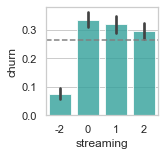


_____________________

tenure 
____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 78.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 52.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


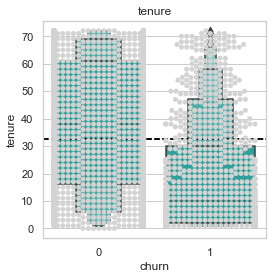

        count       mean        std  min   25%   50%   75%   max
churn                                                           
0      2897.0  37.853642  23.956034  0.0  16.0  38.0  61.0  72.0
1      1046.0  18.327916  19.709773  1.0   2.0  10.0  30.0  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2242516.5, pvalue=1.1957988576110993e-117)

____________________

monthly_charges 
____________________



/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 77.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 53.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


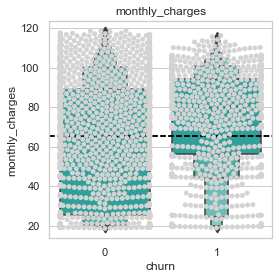

        count       mean        std    min    25%     50%      75%     max
churn                                                                     
0      2897.0  61.680877  31.166578  18.55  25.15  64.900  88.9000  118.65
1      1046.0  74.580115  24.696621  18.85  56.25  79.925  94.3875  116.20 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1160715.0, pvalue=2.891105812698731e-29)

____________________



In [62]:
# Bivariate exploration

# Remove the target (churn), because the target gets its own place
# in the bivariate explore function call
cat_vars_no_target = ['senior_citizen', 'partner', 'dependents','multiple_lines',
            'paperless_billing','contract_type','internet_service_type',
            'payment_type','automatic_pmt','online_utility','streaming']

explore.explore_bivariate(train, 'churn', cat_vars_no_target, quant_vars)

### Takeaways for bivariate exploration:

In [ ]:
# Multivariate exploration using function from explore.py

# explore.explore_multivariate(train, 'churn', cat_vars, quant_vars)
# I received error message saying that points could not be placed on plots,
# and to reduce marker size or use stripplot

# I will attempt to resolve these errors by removing less important categorical features
# Looking at chi2 plots from bivariate analysis:
# only gender and phone service were not statistically significant
# Phone service can also be determined from the multiple lines feature
# I also dropped total_charges because it is totally out of scale with everything else
# Also, monthly charges and tenure are better features than total_charges

# I will next try combining similar features:
# The online features were all utility, and did not seem popular in the univariate analysis
# bells_whistles = online_security + online_backup + tech_support

# streaming_tv and streaming_movies were similar and so were combined into one feature







#explore.explore_multivariate(train, 'churn', cat_vars, quant_vars)



# I don't want to drop chi2 statistically significant features,
# so I will use another method

In [ ]:
# Melt the training subset for exploration
# There are no null values

melted = train.melt(id_vars = 'churn')
melted.info()

In [48]:
melted.head()

,churn,variable,value
0,0,senior_citizen,0.0
1,0,senior_citizen,0.0
2,0,senior_citizen,1.0
3,0,senior_citizen,0.0
4,0,senior_citizen,0.0


<AxesSubplot:xlabel='variable', ylabel='value'>

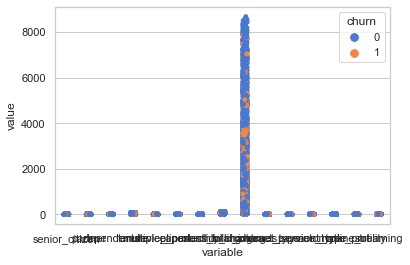

In [49]:
sns.stripplot(data=melted, x='variable', y='value', hue='churn')

In [ ]:
df.info()

In [ ]:
# create X & y version of train, where y is a series with just the target variable 
# and X are all the features except the target variable. 

#X_train = train.drop(columns=['churn'])
#y_train = train.churn

#X_validate = validate.drop(columns=['churn'])
#y_validate = validate.churn

#X_test = test.drop(columns=['churn'])
#y_test = test.churn

In [ ]:
#X_train.head()

In [ ]:
#y_train.head()